In [1]:
from sklearn.neural_network import MLPRegressor as mlp
import sys
sys.path.append("/home/watkinsz/Desktop/For_Zack/ML")
sys.path.append("/home/watkinsz/Desktop/For_Zack/ML/FeH")
from fitsParser.fitsParser import fitsParser
import pandas as pd
import numpy as np
from numpy import linspace
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from modelValidator import psMetric, cut, shuffleDwarfs, plotRes, plot, norm_inputs, monte_carlo, printTable
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from function import save_data


fits = fitsParser(includefile = 'fitsSetup.txt')
fits.data['u']+=0.4 #compensate for percent level offset in ab magnitudes from sdss
fits.makeColours(N=10)
colours = [ 'g-i', 'CaHK-g', 'u-g', 'CaHK-g', 'CaHK-i', 'z-y']
test_colours = ['pristine_col'+x for x in '1234']+['g-i', 'g-r']
def moreCols(fits):
    fits.data['pristine_col4'] = fits.data['u-g']
    fits.data['pristine_col1'] = fits.data['CaHK-g']
    fits.data['pristine_col2'] = fits.data['g-i']
    fits.data['pristine_col3'] = fits.data['u-CaHK']
moreCols(fits)
sdss = fitsParser(includefile = 'FeHdata.txt')
colours = ['pristine_col'+x for x in '412']
fits.data['FeHadop'] = fits.data['FeH']
colours = fits.colours
#fits.makeColours(N=10)
#colours = fits.colours

data = pd.DataFrame(fits.data)
data = shuffle(data)
l = lambda col : (data[col]>0)&(data[col]<2)
#data[fits.colours] += np.random.normal(scale = 0.1, size = (len(data),len(fits.colours)))
#data['FeH'] += np.random.normal(scale = 0.15, size = len(data))
nn = True
train_in, test_in, train_out, test_out = train_test_split(data[colours], data['FeH'], test_size = 0.2 if nn else 0.7, shuffle = False)
data['test_flag'] = [0]*len(train_in)+[1]*len(test_in)



Using TensorFlow backend.


In [2]:
if nn:
    params = {
        'hidden_layer_sizes' : (32,32,32,32,32,32,32),
        'max_iter' : 500, 
        'verbose' : True,
        'batch_size' :100,
        'tol' : 1e-10
    }

    model = mlp(**params)
    model.fit(train_in.values, np.ravel(train_out))
else:
    kernel1 = RBF(length_scale = 0.5)
    kernel2 = WhiteKernel(noise_level = 0.6)
    kernel = kernel1 + kernel2


    params = {
        'kernel' : kernel,
        'n_restarts_optimizer' : 0,
        'normalize_y' : True,
        'copy_X_train' : False,
        'alpha' : 1e-4
    }



    model = gpr(**params)
    model.fit(train_in, np.ravel(train_out))

Iteration 1, loss = 0.58684491
Iteration 2, loss = 0.27391209
Iteration 3, loss = 0.24310074
Iteration 4, loss = 0.21623418
Iteration 5, loss = 0.19685473
Iteration 6, loss = 0.18070312
Iteration 7, loss = 0.16969313
Iteration 8, loss = 0.17355155
Iteration 9, loss = 0.16039578
Iteration 10, loss = 0.15382788
Iteration 11, loss = 0.14970683
Iteration 12, loss = 0.15197649
Iteration 13, loss = 0.14681806
Iteration 14, loss = 0.14341425
Iteration 15, loss = 0.13508316
Iteration 16, loss = 0.13442992
Iteration 17, loss = 0.14366927
Iteration 18, loss = 0.12842526
Iteration 19, loss = 0.12907783
Iteration 20, loss = 0.12417497
Iteration 21, loss = 0.12952065
Iteration 22, loss = 0.12709178
Iteration 23, loss = 0.13118596
Iteration 24, loss = 0.12587032
Iteration 25, loss = 0.12345364
Iteration 26, loss = 0.12507346
Iteration 27, loss = 0.12445714
Iteration 28, loss = 0.11912174
Iteration 29, loss = 0.11613513
Iteration 30, loss = 0.11607321
Iteration 31, loss = 0.11886226
Iteration 32, los

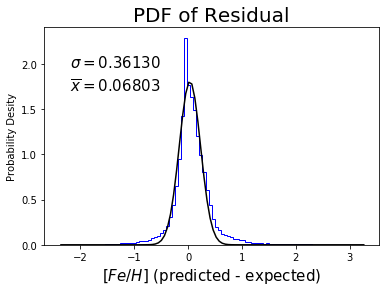

In [3]:

data['FeH_pred'] = model.predict(data[colours])
data['res'] = data['FeH_pred'] - data['FeH']
#plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plot(data['res'])


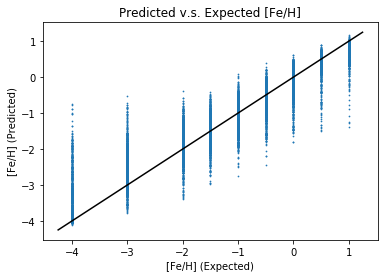

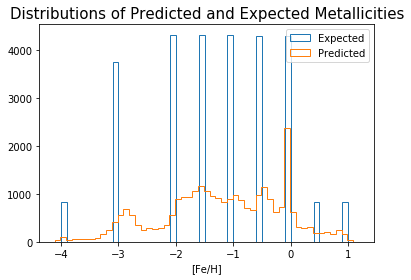

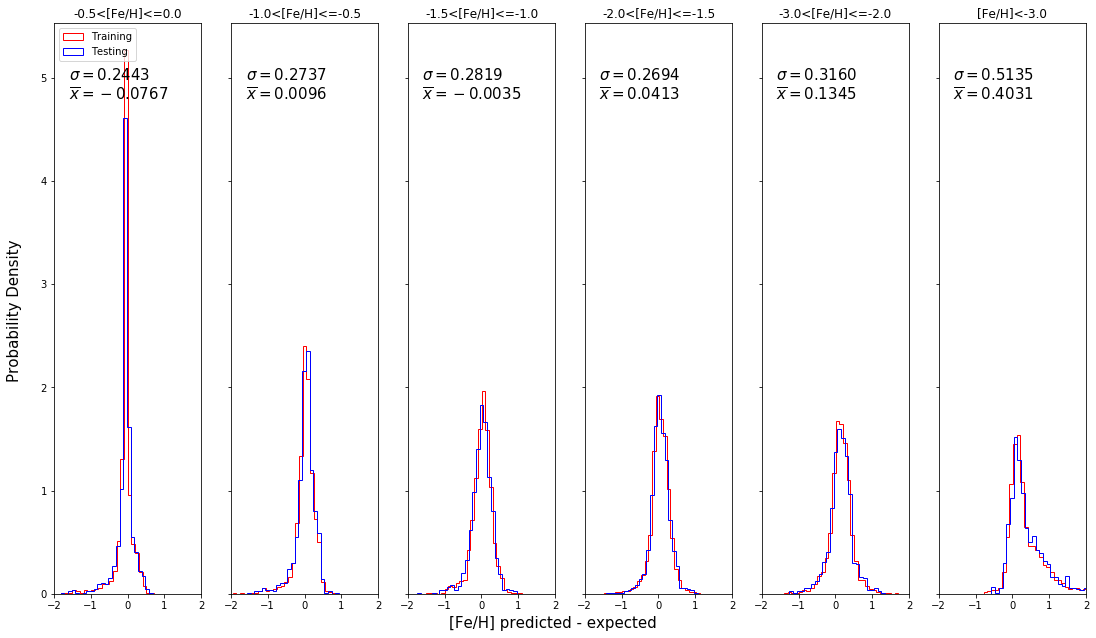

| [Fe/H]< | purity | completness |
----------------------------------
| 0.0     | 0.9954 | 0.9616      |
| -1.0    | 0.9835 | 0.8528      |
| -2.0    | 0.9724 | 0.6081      |
| -2.5    | 0.9644 | 0.7863      |
| -3.0    | 0.9874 | 0.2920      |
| -4.0    | 1.0000 | 0.0471      |



In [4]:
def makePlots(outputSDSS, pred = 'FeH_pred', adop = 'FeH', res ='res'):
    #plot((outputSDSS[res])[outputSDSS['test_flag']==-1])

    plt.scatter(outputSDSS[adop], outputSDSS[pred] , s = 0.5)
    plt.title('Predicted v.s. Expected [Fe/H]')
    plt.xlabel('[Fe/H] (Expected)')
    plt.ylabel('[Fe/H] (Predicted)')
    x = np.linspace(max((plt.xlim())[0], (plt.ylim())[0]), min((plt.xlim())[1], (plt.ylim())[1]))
    plt.plot(x,x, color = 'black')
    plt.show()


    getbins = lambda data, size = 0.1 : np.arange(min(data), max(data) + size, size)
    den = False
    getNbins = lambda data, s ,size = 0.1 : int((np.max(data[s])-np.min(data[s]))/size)
    try:
        plt.hist((outputSDSS[pred])[outputSDSS['test_flag']==-1], bins  = getbins((outputSDSS[pred])[outputSDSS['test_flag']==-1]),  histtype = 'step', label = 'Predicted | [Fe/H]>%.1f'%metCut, density = den)
    except ValueError:
        pass
    plt.hist((outputSDSS[adop]), bins = getbins((outputSDSS[adop])), histtype = 'step', label = 'Expected', density = den)
    plt.hist((outputSDSS[pred])[outputSDSS['test_flag']>=0], bins=getbins((outputSDSS[pred])[outputSDSS['test_flag']>=0]),  histtype = 'step', label = 'Predicted', density = den)
    plt.xlabel('[Fe/H]')
    plt.title('Distributions of Predicted and Expected Metallicities', fontsize = 15)
    plt.legend(loc = 'upper right')
    plt.show()


    bins = [0, -0.5, -1,-1.5, -2 , -3]
    f,  z = plt.subplots(1, len(bins), sharex='all', sharey='row')
    plt.xlim(-2,2)
    f.set_size_inches(18.5, 10.5)
    for i in range(len(bins)):
        if (i==len(bins)-1):
            sub = outputSDSS[outputSDSS[adop]<=bins[i]]
        else:
            sub = outputSDSS[(outputSDSS[adop]<=bins[i])&(outputSDSS[adop]>bins[i+1])]
        Title = '%.1f<[Fe/H]<=%.1f' %(bins[i+1] ,bins[i]) if i+1 in range(len(bins)) else '[Fe/H]<%.1f'%bins[i]
        plotRes((sub[sub['test_flag']!=0])[res], (sub[sub['test_flag']==0][res]), toPlot = z[i],title = Title, normalFit = False, xy = (0.1 , 0.9))
    z[0].legend(loc = 'upper left')
    f.text(0.5, 0.08, '[Fe/H] predicted - expected', ha='center', fontsize = 15)
    f.text(0.09, 0.5, 'Probability Density', va='center', rotation='vertical', fontsize = 15)
    plt.show()
    
makePlots(data)
i = [0,-1,-2,-2.5,-3,-4]
data['FeHadop'] = data['FeH']
pur, com = psMetric(data, inc = i)
print printTable(i, pur, com)


Data saved

condition on dFeHadop cut 17 inputs
2.99% of inputs cut
| [Fe/H]< | purity | completness |
----------------------------------
| 0.0     | 1.0000 | 0.9956      |
| -1.0    | 1.0000 | 0.9765      |
| -2.0    | 1.0000 | 0.9457      |
| -2.5    | 0.3953 | 0.9961      |
| -3.0    | 0.0735 | 1.0000      |
| -4.0    | 0.0018 | 1.0000      |


Data saved



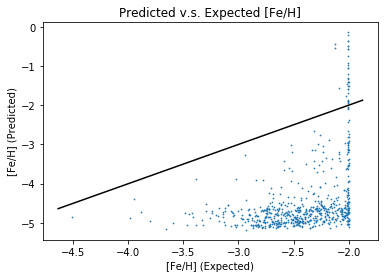

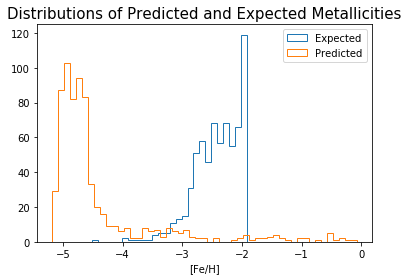

/home/watkinsz/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


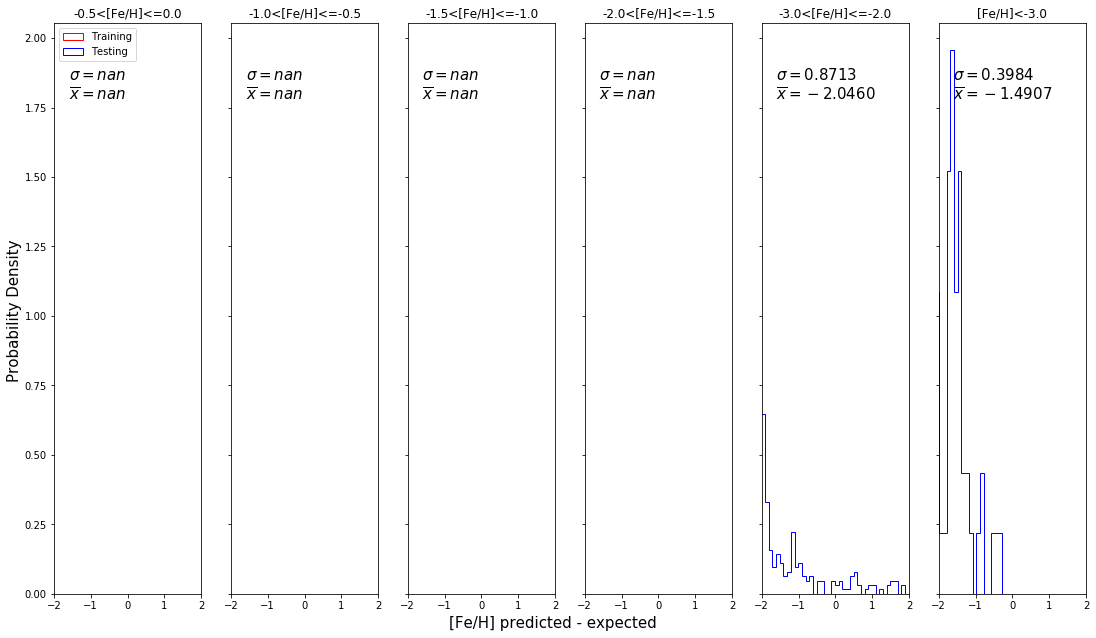

In [5]:
def getMags(colour):
    return colour[:colour.index('-')], colour[colour.index('-')+1:]


youc = sdss.getAllObj()[1]
cut(youc, metThresh = -5)
youc.makeColours(N=10)
conversion = {
    'CaHK_0' : 'CaHK' 
}
conversion.update({x+'_fpsf' : x for x in 'grizy'})
conversion.update({x+'_0' :x for x in 'ugri'})
for col in youc.colours:
    mag1, mag2 = getMags(col)
    youc.data[conversion[mag1]+'-'+conversion[mag2]] = youc.data[col]


for field in youc.data.keys():
    if field in conversion:
        youc.data[conversion[field]]= youc.data[field]
    
youc.data['pristine_col4'] = youc.data['u-g']
youc.data['pristine_col1'] = youc.data['CaHK-g']
youc.data['pristine_col2'] = youc.data['g-i']
youc.data['pristine_col3'] = youc.data['u-CaHK']
youc.data['FeH_pred'] = model.predict(youc.data[colours])
youc.data = youc.data[youc.data['FeH_pred']>-10]
youc.data['res'] = youc.data['FeH_pred'] - youc.data['FeHadop']
youc.data['test_flag'] = 1
 
pur , com  = psMetric(youc.data, inc = i)
print printTable(i, pur , com)
save_data(youc.data, 'out3.asc')
makePlots(youc.data[youc.data['FeH_pred']<0], adop = 'FeHadop')

In [6]:
save_data(data, 'train.asc')


Data saved

